# <span id="chap_epidemic_gillespie"></span> Gillespie simulation

We can both improve the statistical properties of simulations and imporve their performance by changing the simulation approach we use. We *won't* try to optimise or improve the performance of synchrnous dynamics: instead, we'll *replace* the synchronous approach with another technique that (it turns out) is better-suited to simulating large systems accurately.

The technique we use is sometimes called *Gillespie's stochastic siumulation algorithm* or simply *Gillespie simulation*, It was developed initially [[Gil76]](bibliography.ipynb#Gil76)[[Gil77]](bibliography.ipynb#Gil77) to perform *ab initio* chemical simulations, where a lot of molecules react according to a set of simple chemical rules &ndash; a situation that's very similar to a process over a network. Cao *et alia* [[CGP06, section II]](bibliography.ipynb#CGP06) provides a very accessible description to the basic mathematics of the technique, which we'll develop in a network context below.

The essence of Gillespie simulation is the observation that we can manipulate the probabilities governing events. Instead of testing in every timestep which of the available eventscan occur (for example from susceptible to infected), we predict the next timestep at whcih the next event will occur &ndash; skipping the intermediate timesteps where nothing happens. To put this another way, we convert the probabilities of individual events in space into aggregate probability distributions over time. If the simulation is such that a lot of "empty" timesteps occur, then this approach will avoid the costs of simulating them.

In [29]:
import networkx
import math
import numpy
import pickle
import time

from cncp import *

import pandas as pd

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

## <span id="sec_epidemic_gillespie_maths"></span> From single-step to interval behaviour

In the synchronous simulation in the [previous chapter](epidemic-synchronous.ipynb) we evaluated the dynamics at each infected node, since these are the loci for all changes in the network's state. However, it might be fairer to say that the dynamics actually occurs at two loci. Recovery happens at infected nodes; but infection happens at edges connecting an infected node to a susceptible node, the so-called *SI edges*. (We can also identify SS, SR, II, and RR edges, and these play important r&ocirc;les in some epidemic models, although not in SIR.) SIR assumes that the dynamics occurs at these loci independently. If we denote the probability of an SI edge transmitting an infection (*becoming occupied*, in percolation terminology) as $\alpha$, then the probability of some edge of the network becoming occupied in a timestep is given by $\alpha [SI]$ where $[SI]$ denotes the nunber of SI edges in the network. $[SI]$ is of course a function of time, since the population of SI edges is changed by the infection event. Similarly is infected nodes recover with probability $\beta$ the probability that some node will recover in a timestep is given by $\beta [I]$. In a sense the values of $[SI]$ and $[I]$ constitute the "state" of the dynamical system. Each infection event will decrease $[SI]$ by one and increase $[I]$ by a value that depends on the degree of the newly-infected node and how many of those adjacent nodes are susceptible. This indicates that the dynamics entwines three distinct features:

1. the probabilities of different events;
1. the number of loci at which these events can occur; and
1. the topology of the network that controls how the populations of loci evolve.

It is this third feature that distinguishes the network formulation from the differential equation formulation, since it allows heterogeneity of evolution in both space and time.

A lot of probabilistic arguments are better conducted in a continuous-time model, so let us re-formulate the above in this way. The probability that some SI edge will transmit infection in a small time $dt$ is given by $a_I \, dt = \alpha [SI] \, dt$, and recovery similarly by $a_R \, dt = \beta [I] \, dt$. We can now ask two questions: given the state of the network,

1. when will the next event occur?, and
1. what event will it be?

Clearly these are probabilistic questions, the answers to which will be formulated as probability distributions. We define $P(\tau, e) \, d\tau$ as the probability that an event will happen in the interval $(t + \tau, t + \tau + d\tau)$ *and* that that event will be of type $e$, which for SIR will be either an infection ($I$) or a recovery ($R$) event. This is a joint probability density function on the space of the $\tau$ and $e$ variables: note also that the value of $\tau$ answers the first question above, while the value of $e$ answers the second.

### The distribution of events in time

To compute $P(\tau, e) \, d\tau$, we can observe that it is the product of two components: the probability that no event occurs in the interval $(t, t + \tau)$; and that an event $e$ occurs in the interval $(t + \tau, t + \tau + d\tau)$:

$$
    P(\tau, e) \, d\tau = P_0(\tau) \, a_e \, d\tau
$$

where $P_0(\tau)$ is the probability of no event happening in $(t + \tau)$.

Since we already know the values of $a_e$ from the model parameters ($\alpha$ and $\beta$) and the size of the appropriate sub-populations ($[SI]$ and $[I]$), we need an expression for $P_0(\tau)$. Let $a \, d\tau' = \sum_e a_e \, d\tau'$ be the probability that *some* event happens in an interval $d\tau'$, simply by summing-up the component probabilities of the different events. We then have:

$$
    P_0(\tau' + d\tau') = P_0(\tau') \, (a \, d\tau')
$$

the probability that no event occurs in in the interval $(t, t + \tau)$ and that one then occured in the following interval $d\tau'$. This is a differential equation that is solved by:

$$
    P_0(\tau) = e^{-a \tau}
$$

Substituting back into the above we therefore have:

\begin{align*}
    P(\tau, e) &= P_0(\tau) \, a_e \\
               &= a_e \, e^{-a \tau}
\end{align*}

To conduct simulation, we need to be able to draw a pair $(\tau, e)$ from this distribution. Note that because this is a joint probability distribution we cannot choose the two independently: the value of $P(\tau, e)$ depends on *all* the possible events $e$ because of the presence of $a$ in its definition. However, any joint probability distribution $P(a, b)$ can be re-written as $P(a, b) = P(a) \, P(b | a)$, the product of prior probability of $a$ and the probability of $b$ given that $a$ has occurred. In our case,

$$
    P(\tau, e) = P(\tau) \, P(e | \tau)
$$

where $P(\tau)$ is the probability that *some* reaction will occur on the interval $(t, t + \tau)$ and $P(e | \tau)$ is the probability that this reaction will be of type $e$ given that it occurs on this interval. Clearly $P(\tau)$ is simply the sum of the probabilities for all the events that may occur,

$$
    P(\tau) = \sum_e P(\tau, e)
$$

and therefore:

$$
    P(e | \tau) = \frac{P(\tau, e)}{\sum_{e'} P(\tau, e')}
$$

These two equations are both single-variable probability distributions (over $\tau$ and $e$ respectively) expressed in terms of the joint probability distribution $P(\tau, e)$, and if we substitute for $P(\tau, e)$ from above we get:

\begin{align*}
    P(\tau)     &= \sum_e a_e e^{-a \tau} \\
                &= a \, e^{-a \tau} \\ \\
    P(e | \tau) &= \frac{P(\tau, e)}{\sum_{e'} P(\tau, e')} \\
                &= \frac{a_e e^{-a \tau}}{a \, e^{-a \tau} } \\
                &= \frac{a_e}{a}
\end{align*}

Note that $P(e | \tau)$ is in this case independent of $\tau$, since the event probabilities are constants.

Let's briefly return to the network scenario we're interested in. The value $\tau$ is the interval of time until the next event occurs in the network, whether that is the infection of the S node attached to an SI edge of the recovery of an I node. *Which* of these events happens is determined by $e$. The pair $(\tau, e)$ therefore fully defines the time and identity of the next event in the simulation. It remains to see how we choose these two values, and how the network evolves in response to the selected event.

### <span id="sec_epidemic_gillespie_drawing_pair"></span> Generating the $(\tau, e)$ pair

In order to make use of $P(\tau, e)$ we have to be able to draw $\tau$ and $e$ from the joint distribution. We saw above that this involves drawing values from $P(\tau)$ and $P(e | \tau)$ individually, with the latter distribution actually being independent of time.

It may not be obvious how to draw from such distributions, but we can manipulate the probabilities to make it possible using only a source of uniformly-distributed random numbers on the range $(0, 1)$, which Python certainly has. The trick is to observe that, for any probability density function $P(a)$, the value $P(a) \, da$ represents the probability that a value drawn from the distribution will lie between $a$ and $(a + da)$. From this we can construct a cumulative distribution function,

$$
    F(x) = \int_{-\infty}^{x} P(a) \, da
$$

where $F(x_0)$ represents the probability that a value drawn from $P(a)$ is less than $x_0$ (also denoted $P(a \le x_0)$). If we now draw a value $r$ from a uniform distribution on $(0, 1)$ we can compute $x = F^{-1}(r)$ where $F^{-1}$ is the inverse of the cumulative distribution function and $x$ will be distributed according to $P(a)$.  This means we can convert a uniformly-distributed value into a value drawn from any probability distribution for which we can construct (and invert) a cumulative distribution function.

In our case we have that $P(\tau) = a \, e^{-a \tau}$, which means that $F(\tau) = 1 - e^{-a \tau}$. This is an awkward expression to manipulate, but we can observe that, if a number $r_1$ is uniformly distributed, then so by definition is $1 - r_1$, so if we set $F(\tau) = 1 - r_1$ we can cancel-out the constant ones and get a simpler expression overall. We then have:

\begin{align*}
      1 - r_1 &= F(\tau) \\
              &= 1 - e^{-a \tau} \\
          r_1 &= e^{-a \tau} \\
              &= \frac{1}{e^{a \tau}} \\
   e^{a \tau} &= \frac{1}{r_1} \\
       a \tau &= \ln \frac{1}{r_1} \\
         \tau &= \frac{1}{a} \, \ln \frac{1}{r_1}
\end{align*}

The discrete case works similarly. If we draw a value $r_2$ on $(0, 1)$, then the value of $e$ we require is given $\sum_{e' = 0}^{e - 1} a_{e'} \leq r_2 a \leq \sum_{e' = 0}^{e} a_{e'}$: the largest $e$ such that the sum of $a_{e'}$ for $e' \le e$ is less than $r_2 a$.

The upshot of all this probability theory is that we can choose a time to the next event $\tau$ and the identity of the next event $e$ from the distributions induced by the individual event probabilities and the number of loci for each event in the network, by drawing two uniformly-distributed numbers and performing a simple calculation [[Gil76]](#Gil76).  

## Simulating stochastic dynamics

We can now cast the above mathematical formulation into a simulation framework, sub-classing our `GraphWithDynamics` class and adding a method to define the abstract stochastic dynamics:

In [55]:
class GraphWithStochasticDynamics(GraphWithDynamics):
    '''A graph with a dynamics that runs stochastically, skipping timesteps
    in which nothing changes.'''
        
    def __init__( self, g = None ):
        '''Create a graph, optionally with nodes and edges copied from
        the graph given.
        
        g: graph to copy (optional)'''
        GraphWithDynamics.__init__(self, g)

    def transitions( self, t ):
        '''Return the transition vector, a sequence of (r, f) pairs
        where r is the rate at which a transition happens and
        f is the transition function called to make it happen. Note that
        it's a rate we want, not a probability.
        
        It's important that the transitions always come in the same order
        in the vector, even though the rates (and indeed functions) can
        change over time.
        
        t: timestep for which we want the transitions
        returns: the transition vector'''
        raise NotYetImplementedError('transitions()')
        
    def _dynamics( self ):
        '''Stochastic dynamics.
        
        returns: a dict of simulation properties'''
        rc = dict()
        
        # set up the priority list
        transitions = self.transitions(0)
        pr = range(len(transitions))
        
        # run the dynamics
        rc['start_time'] = time.clock()
        self.before()
        t = 0
        events = 0
        eventDist = dict()
        while True:
            # pull the transition dynamics at this timestep
            transitions = self.transitions(t)
            
            # compute the total rate of transitions for the entire network
            a = 0.0
            for (r, _) in transitions:
                a = a + r
                
            # calculate the timestep delta
            r1 = numpy.random.random()
            dt = (1.0 / a) * math.log(1.0 / r1)
            t = t + dt
            
            # calculate which transition happens 
            r2 = numpy.random.random()
            xc = r2 * a
            k = 0
            (xs, f) = transitions[pr[k]]
            while xs < xc:
                k = k + 1
                (xsp, f) = transitions[pr[k]]
                xs = xs + xsp

            # if we used a low-priority transition, swap it up the priority queue
            #if k > 0:
            #    p = pr[k - 1]
            #    pr[k - 1] = pr[k]
            #    pr[k] = p       
            
            # perform the transition
            f(t)
            
            # increment the event counter and distribution
            events = events + 1
            eventDist[t] = 1
            
            # check for termination
            if self.at_equilibrium(t):
                break
        self.after()
        rc['end_time'] = time.clock()
        
        # complete statistics
        rc['elapsed_time'] = rc['end_time'] - rc['start_time']
        rc['timesteps'] = t
        rc['events'] = events
        rc['event_distribution'] = eventDist
        rc['node_types'] = self.populations()        
        return rc

The important part of this  class is the `_dynamics()` method, which implements a mechanism for drawing the $(\tau, e)$ pair as described [above](#sec_epidemic_gillespie_drawing_pair). In the code, `dt` is the interval to the next event, while `xc` is used to choose the event that occurs. The `transisions()` method is overridden in sub-classes to return a list mapping rates of events to the function used to apply the event, which `_dynamics()` then uses to perform the event at the appropriate timestep.

Defining the SIR process in this dynamics involves keeping track of the loci of the dynamics, the I nodes and SI edges. We re-define equilibrium to happen when the pool of infected nodes is exhausted. The event rates are simply the event probabilities multiplied by the number of loci for each event, while the transition functions are methods to `infect()` or `recover()` a node and update the lists of available loci. (The rest of the class is very similar to the SIR dynamics built on top of a synchronous simulation.) 

In [66]:
class SIRStochasticDynamics(GraphWithStochasticDynamics):
    '''An SIR dynamics with stochastic simulation.'''

    # keys for node and edge data
    DYNAMICAL_STATE = 'sir'   # dynamical state of a node
    
    # the possible dynamics states of a node for SIR dynamics
    SUSCEPTIBLE = 'S'
    INFECTED = 'I'
    RECOVERED = 'R'
    
    # list of infected nodes, the sites of all the dynamics
    _infected = []
    
    # list of SI edges connecting a susceptible to an infected node
    _si = []
        
    def __init__( self, pInfect = 0.0, pRecover = 1.0, pInfected = 0.0, g = None ):
        '''Generate a graph with dynamics for the given parameters.
        
        pInfect: infection probability (defaults to 0.0)
        pRecover: probability of recovery (defaults to 1.0)
        pInfected: initial infection probability (defaults to 0.0)
        g: the graph to copy from (optional)'''
        GraphWithStochasticDynamics.__init__(self, g)
        self._pInfect = pInfect
        self._pRecover = pRecover
        self._pInfected = pInfected
        
    def before( self ):
        '''Seed the network with infected nodes, extract the initial set of
        SI nodes, and mark all edges as unoccupied by the dynamics.'''
        self._infected = []       # in case we re-run from a dirty intermediate state
        self._si = []
        
        # infect nodes
        for n in self.node.keys():
            if numpy.random.random() <= self._pInfected:
                self._infected.insert(0, n)
                self.node[n][self.DYNAMICAL_STATE] = self.INFECTED
            else:
                self.node[n][self.DYNAMICAL_STATE] = self.SUSCEPTIBLE
                
        # extract the initial set of SI edges
        for (n, m, data) in self.edges_iter(self._infected, data = True):
            self._si.insert(0, (n, m, data))
        
        # mark all edges as unoccupied
        for (n, m, data) in self.edges_iter(data = True):
            data[self.OCCUPIED] = False
            
    def at_equilibrium( self, t ):
        '''SIR dynamics is at equilibrium if there are no more infected nodes left
        in the network, no susceptible nodes adjacent to infected nodes, or if we've
        exceeded the default simulation length.
        
        t: the current time
        returns: True if the model has stopped'''
        if t >= 20000:
            return True
        else:
            return (len(self._infected) == 0)
        
    def infect( self, t ):
        '''Infect a node chosen at random from the SI edges.'''
        
        # choose an SI edge
        i = int(numpy.random.random() * len(self._si))
        (n, m, data) = self._si[i]
        
        # infect the susceptible end
        self._infected.insert(0, m)
        self.node[m][self.DYNAMICAL_STATE] = self.INFECTED
        
        # label the edge we traversed as occupied
        data[self.OCCUPIED] = True
        
        # remove all edges in the SI list from an infected node to this one
        self._si = [ (np, mp, data) for (np, mp, data) in self._si if m != mp ]
        
        # add all the edges incident on this node connected to susceptible nodes
        for (_, mp, datap) in self.edges_iter(m, data = True):
            if self.node[mp][self.DYNAMICAL_STATE] == self.SUSCEPTIBLE:
                self._si.insert(0, (m, mp, datap))

    def recover( self, t ):
        '''Cause a node to recover.'''
        
        # choose an infected node at random
        i = int(numpy.random.random() * len(self._infected))
        n = self._infected[i]
        
        # mark the node as recovered
        del self._infected[i]
        self.node[n][self.DYNAMICAL_STATE] = self.RECOVERED
        
        # remove all edges in the SI list incident on this node
        self._si = [ (np, m, e) for (np, m, e) in self._si if np != n ]
        
    def transitions( self, t ):
        '''Return the transition vector for the dynamics.
        
        t: time (ignored)
        returns: the transition vector'''
        
        # transitions are expressed as rates, whereas we're specified
        # in terms of probabilities, so we convert the latter to the former.
        return [ (len(self._si) * self._pInfect,        lambda t: self.infect(t)),
                 (len(self._infected) * self._pRecover, lambda t: self.recover(t)) ]
            
    def dynamics( self ):
        '''Returns statistics of outbreak sizes. This skeletonises the
        network, so it can't have any further dynamics run on it.
        
        returns: a dict of statistical properties'''
        
        # run the basic dynamics
        rc = self._dynamics()
        
        # compute the limits and means
        cs = sorted(networkx.connected_components(self.skeletonise()), key = len, reverse = True)
        max_outbreak_size = len(cs[0])
        max_outbreak_proportion = (max_outbreak_size + 0.0) / self.order()
        mean_outbreak_size = numpy.mean([ len(c) for c in cs ])
        
        # add parameters and metrics for this simulation run
        rc['pInfected' ] = self._pInfected,
        rc['pRecover'] = self._pRecover,
        rc['pInfect'] = self._pInfect,
        rc['N'] = self.order(),
        rc['mean_outbreak_size'] = mean_outbreak_size,
        rc['max_outbreak_size'] = max_outbreak_size,
        rc['max_outbreak_proportion'] = max_outbreak_proportion
        return rc

We can now take the same parameters as we used in the [synchronous case](epidemic-synchronous.ipynb#sec_epidemic_synchronous_sir_simulation):

In [67]:
# disease parameters
pInfected = 0.001
pInfect = 0.01
pRecover = 0.0002

# network parameters for an ER network
N = 5000
pEdge = 0.004

Plugging these parameters into our new simulation class, we get:

In [68]:
sto = SIRStochasticDynamics(pInfected = pInfected, pInfect = pInfect, pRecover = pRecover,
                            g = networkx.erdos_renyi_graph(N, pEdge))
sto_dyn = sto.dynamics()

with open('sto-sir.pickle', 'wb') as handle:
    pickle.dump(sto_dyn, handle)

We can look at several of the same factors that we looked at for the synchronous case. Firstly, the size of epidemic should be the same, given that the simulation parameters were identical, with the proviso that both simulations have a large amount of randomness in them that will preclude identical results: 

In [69]:
print "Epidemic covered {percent:.2f}% of the network".format(percent = sto_dyn['max_outbreak_proportion'] * 100)

Epidemic covered 19.68% of the network


We can at least say that both simulations have produced an epidemic (or some size) for these parameter values.

We can further look at the distribution of events in time. To do this we extract the `event_distribution` value, a dict mapping a time to the number of events occurring at that time. The keys of this dict give the times at which events occurred, and we can generate a histogram of these values to show the distribution:

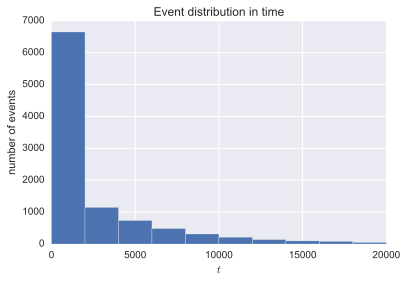

In [70]:
df = pd.DataFrame({ 'd': sto_dyn['event_distribution'].keys() })
df.hist()

plt.xlim([0, 20000])
plt.xlabel("$t$")
plt.ylabel("number of events")
plt.title("Event distribution in time")
plt.show()

## Comparison

We can compare the overall results of the two approaches. First we load both datasets:

In [71]:
with open('syn-sir.pickle', 'rb') as handle:
    syn_dyn = pickle.load(handle)
with open('sto-sir.pickle', 'rb') as handle:
    sto_dyn = pickle.load(handle)

We can then look at the different node types at equilibrium:

In [72]:
print "Node type sub-populations:"
print "Synchronous:", syn_dyn['node_types']
print "Stochastic:", sto_dyn['node_types']

Node type sub-populations:
Synchronous: {'I': 75, 'R': 4925}
Stochastic: {'I': 86, 'R': 4914}


We can also look at time time taken to run the simulation:

In [76]:
print "Elapsed simulation times:"
print "Synchronous {elapsed:.2f}s".format(elapsed = syn_dyn['elapsed_time'])
print "Stochastic  {elapsed:.2f}s".format(elapsed = sto_dyn['elapsed_time'])

Elapsed simulation times:
Synchronous 379.53s
Stochastic  112.34s


The reduction is a consequence of the number of "unnecessary" timesteps in the synchronous implementation.

Although we are using two different simulation techniques, we claim that they are "the same" in the sense of simulating the same process dynamics. One way to test this is to look at the distance between successive events. If the events are happening with similar distributions, we would expect the inter-event time distributins to be similar too:

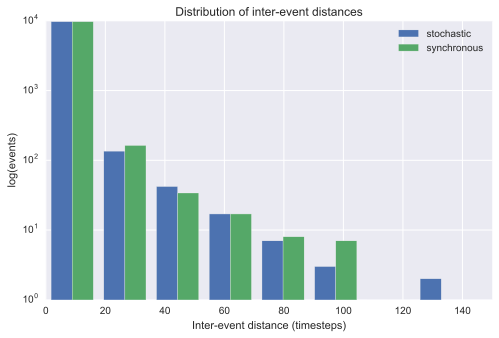

In [89]:
fig = plt.figure(figsize = (8, 5))
plt.title('Distribution of inter-event distances')
plt.xlabel('Inter-event distance (timesteps)')
plt.ylabel('log(events)')

# work out inter-event distances
l = 0
syn_dist = []
for i in sorted(syn_dyn['event_distribution'].keys()):
    for j in range(syn_dyn['event_distribution'][i]):
        syn_dist.append(i - l)
    l = i
sto_dist = []
l = 0
for i in sorted(sto_dyn['event_distribution'].keys()):
    sto_dist.append(i - l)
    l = i

# plot the histogram of the distribution
plt.hist([sto_dist, syn_dist],
         bins = 20,
         log = True,
         label = ['stochastic', 'synchronous'])

# cut off the plot at a reasonable point
plt.xlim([0, 150])

plt.legend()
_ = plt.show()

Clearly the two approaches are the same over the majority of differences, diverging slightly where there are long (and infrequent) inter-event gaps. The drop-off is exponential as expected.